In [1]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import torch
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

from data_utility import *
from data_utils import *
from loss import *
from train import *
from dense_vnet.DenseVNet import DenseVNet
from sync_batchnorm import convert_model
import datetime

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
USE_GPU = True
NUM_WORKERS = 12
BATCH_SIZE = 2

dtype = torch.float32 
# define dtype, float is space efficient than double

if USE_GPU and torch.cuda.is_available():
    
    device = torch.device('cuda')
    
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
    # magic flag that accelerate
    
    print('using GPU for training')
else:
    device = torch.device('cpu')
    print('using CPU for training')

using GPU for training


In [3]:
train_dataset = pyramid_dataset(data_type = 'nii_train', 
                transform=transforms.Compose([
                random_affine(90, 15),
                random_filp(0.5)]))
# do data augumentation on train dataset

validation_dataset = pyramid_dataset(data_type = 'nii_test', 
                transform=None)
# no data augumentation on validation dataset

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                    num_workers=NUM_WORKERS)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True,
                    num_workers=NUM_WORKERS) # drop_last
# loaders come with auto batch division and multi-thread acceleration

In [4]:
"""
deeplab = DeepLab(output_stride=16)
deeplab = nn.DataParallel(deeplab)
deeplab = convert_model(deeplab)
deeplab = deeplab.to(device=device, dtype=dtype)
#shape_test(icnet1, True)
# create the model, by default model type is float, use model.double(), model.float() to convert
# move the model to desirable device

optimizer = optim.Adam(deeplab.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
epoch = 0

# create an optimizer object
# note that only the model_2 params and model_4 params will be optimized by optimizer
"""

"\ndeeplab = DeepLab(output_stride=16)\ndeeplab = nn.DataParallel(deeplab)\ndeeplab = convert_model(deeplab)\ndeeplab = deeplab.to(device=device, dtype=dtype)\n#shape_test(icnet1, True)\n# create the model, by default model type is float, use model.double(), model.float() to convert\n# move the model to desirable device\n\noptimizer = optim.Adam(deeplab.parameters(), lr=1e-2)\nscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)\nepoch = 0\n\n# create an optimizer object\n# note that only the model_2 params and model_4 params will be optimized by optimizer\n"

In [6]:
dense_vnet = DenseVNet(num_classes=3)
dense_vnet = nn.DataParallel(dense_vnet)
dense_vnet = convert_model(dense_vnet)

checkpoint = torch.load('../dense_vnet_dropout_save/2019-08-12 07:06:41.939284 epoch: 996.pth')

dense_vnet.load_state_dict(checkpoint['state_dict_1'])
dense_vnet = dense_vnet.to(device=device, dtype=dtype)

optimizer = optim.Adam(dense_vnet.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

optimizer.load_state_dict(checkpoint['optimizer'])
scheduler.load_state_dict(checkpoint['scheduler'])
epoch = checkpoint['epoch']
print(epoch)

996


In [ ]:
epochs = 5000

record= open('train_deeplab_least_dilation.txt','a')

logger = {'train':[], 'validation_1': []}

min_val = 0.0643

for e in tqdm(range(epoch + 1, epochs)):
# iter over epoches

    epoch_loss = 0
        
    for t, batch in enumerate(train_loader):
    # iter over the train mini batches
    
        deeplab.train()
        # Set the model flag to train
        # 1. enable dropout
        # 2. batchnorm behave differently in train and test
        
        image_1 = batch['image1_data'].to(device=device, dtype=dtype)
        label_1 = batch['image1_label'].to(device=device, dtype=dtype)
        # move data to device, convert dtype to desirable dtype
        
        out_1 = deeplab(image_1)
        # do the inference

        loss_1 = dice_loss_3(out_1, label_1)
        # calculate loss
        
        epoch_loss += loss_1.item()
        # record minibatch loss to epoch loss
        
        optimizer.zero_grad()
        # set the model parameter gradient to zero
        
        loss_1.backward()
        # calculate the gradient wrt loss
        optimizer.step()
        #scheduler.step(loss_1)
        # take a gradient descent step
        
    outstr = 'Epoch {0} finished ! Training Loss: {1:.4f}'.format(e, epoch_loss/(t+1)) + '\n'
    
    logger['train'].append(epoch_loss/(t+1))
    
    print(outstr)
    record.write(outstr)
    record.flush()

    if e%5 == 4:
    # do validation every 5 epoches
    
        deeplab.eval()
        # set model flag to eval
        # 1. disable dropout
        # 2. batchnorm behave differs

        with torch.no_grad():
        # stop taking gradient
        
            #valloss_4 = 0
            #valloss_2 = 0
            valloss_1 = 0
            
            for v, vbatch in enumerate(validation_loader):
            # iter over validation mini batches
                
                image_1_val = vbatch['image1_data'].to(device=device, dtype=dtype)
                if get_dimensions(image_1_val) == 4:
                    image_1_val.unsqueeze_(0)
                label_1_val = vbatch['image1_label'].to(device=device, dtype=dtype)
                if get_dimensions(label_1_val) == 4:
                    label_1_val.unsqueeze_(0)
                # move data to device, convert dtype to desirable dtype
                # add one dimension to labels if they are 4D tensors
                
                out_1_val = deeplab(image_1_val)
                # do the inference
                
                loss_1 = dice_loss_3(out_1_val, label_1_val)
                # calculate loss

                valloss_1 += loss_1.item()
                # record mini batch loss
            avg_val_loss = (valloss_1/(v+1))
            outstr = '------- 1st valloss={0:.4f}'\
                .format(avg_val_loss) + '\n'
            
            logger['validation_1'].append(avg_val_loss)
            scheduler.step(avg_val_loss)
            
            print(outstr)
            record.write(outstr)
            record.flush()
            
            if avg_val_loss < min_val:
                print(avg_val_loss, ' <', min_val)
                min_val = avg_val_loss
            
            save_1('deeplab_dilated_save', deeplab, optimizer, logger, e, scheduler)

record.close()

1it [00:40, 40.71s/it]

0.003099799156188965 0.06876546144485474 0.14411699771881104 0.07199408859014511


2it [00:42, 29.05s/it]

0.0032507777214050293 0.08158218860626221 0.10464191436767578 0.0631582960486412


3it [00:44, 20.94s/it]

0.003989100456237793 0.09182941913604736 0.11820483207702637 0.0713411197066307


4it [00:46, 15.22s/it]

0.0038231611251831055 0.080466628074646 0.08756786584854126 0.05728588625788689


5it [00:48, 11.29s/it]

0.0035443902015686035 0.08135908842086792 0.1446012258529663 0.07650157064199448


6it [00:50,  8.48s/it]

0.0034124255180358887 0.07014751434326172 0.14869749546051025 0.07408581674098969


7it [00:52,  6.58s/it]

0.0038985013961791992 0.08604574203491211 0.14149749279022217 0.07714724540710449


8it [00:54,  5.18s/it]

0.0034416913986206055 0.08151090145111084 0.13792598247528076 0.0742928609251976


9it [00:56,  4.25s/it]

0.00472790002822876 0.06037890911102295 0.16510367393493652 0.07673683017492294


10it [00:58,  3.55s/it]

0.0036132335662841797 0.07026487588882446 0.12537145614624023 0.06641652435064316


11it [01:00,  3.09s/it]

0.003146648406982422 0.06408452987670898 0.14567863941192627 0.07096993923187256


12it [01:02,  2.73s/it]

0.0032595396041870117 0.06183654069900513 0.19763857126235962 0.08757822215557098


13it [01:04,  2.52s/it]

0.003902435302734375 0.06365799903869629 0.129766583442688 0.06577567756175995


14it [01:06,  2.32s/it]

0.0038571953773498535 0.07381963729858398 0.12996506690979004 0.06921397149562836


15it [01:08,  2.23s/it]

0.0035901665687561035 0.07939291000366211 0.1300540566444397 0.07101237773895264


16it [01:10,  2.12s/it]

0.003646373748779297 0.06453454494476318 0.1787126660346985 0.08229786157608032


17it [01:12,  2.10s/it]

0.004130721092224121 0.08225703239440918 0.12202149629592896 0.06946974992752075
0.0029752254486083984 0.10041308403015137 0.09390825033187866 0.06576552242040634


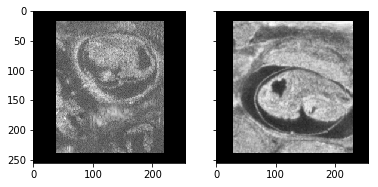

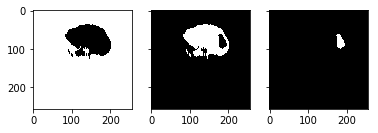

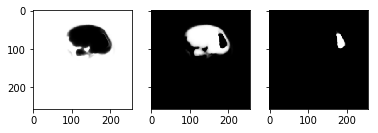

19it [01:17,  2.33s/it]

0.003397643566131592 0.07077336311340332 0.16279447078704834 0.07898849248886108
0.0025587081909179688 0.06434154510498047 0.27366429567337036 0.1135215163230896


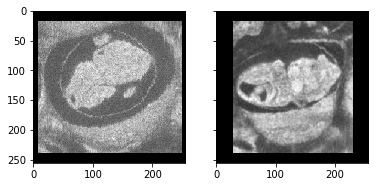

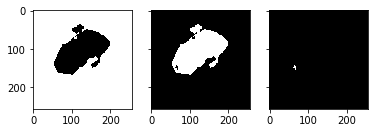

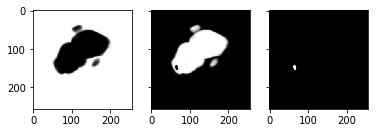

21it [01:22,  2.42s/it]

0.003035426139831543 0.0749216079711914 0.09781324863433838 0.05859009549021721


22it [01:24,  2.26s/it]

0.0044133663177490234 0.05830496549606323 0.17551934719085693 0.0794125646352768


23it [01:26,  2.19s/it]

0.004970431327819824 0.06429529190063477 0.16820049285888672 0.07915540784597397
------- background loss = 0.0036, body loss = 0.0737, bv loss = 0.1445



In [7]:
dense_vnet.eval()

with torch.no_grad():
    
    bgloss = 0
    bdloss = 0
    bvloss = 0
    
    for v, vbatch in tqdm(enumerate(validation_loader)):
            # move data to device, convert dtype to desirable dtype

        image_1 = vbatch['image1_data'].to(device=device, dtype=dtype)
        label_1 = vbatch['image1_label'].to(device=device, dtype=dtype)

        output = dense_vnet(image_1)
        # do the inference
        output_numpy = output.cpu().numpy()
        
        
        #out_1 = torch.round(output)
        out_1 = torch.from_numpy((output_numpy == output_numpy.max(axis=1)[:, None]).astype(int)).to(device=device, dtype=dtype)
        loss_1 = dice_loss_3(out_1, label_1)

        bg, bd, bv = dice_loss_3_debug(out_1, label_1)
        # calculate loss
        print(bg.item(), bd.item(), bv.item(), loss_1.item())
        bgloss += bg.item()
        bdloss += bd.item()
        bvloss += bv.item()
        
        if bv.item() >= 0.2 or bd.item() >= 0.1:
            show_image_slice(image_1)
            show_image_slice(label_1)
            show_image_slice(output)

    outstr = '------- background loss = {0:.4f}, body loss = {1:.4f}, bv loss = {2:.4f}'\
        .format(bgloss/(v+1), bdloss/(v+1), bvloss/(v+1)) + '\n'
    
    #print(bdloss, v)
    print(outstr)